<a href="https://colab.research.google.com/github/Akshajaease123/Comparision-of-different-LLMs-in-dialogue-Summarisation/blob/main/comparision_of_llm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets sacrebleu matplotlib torch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install google-generativeai

In [ ]:
!pip install rouge-score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=b7559148430972e3fee5108c1b45a902a278419aac0dffb7f133705edbf1d7b3
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


Benchmarking Flan-T5...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Benchmarking BART...
Benchmarking GPT-2...
Benchmarking Gemini...


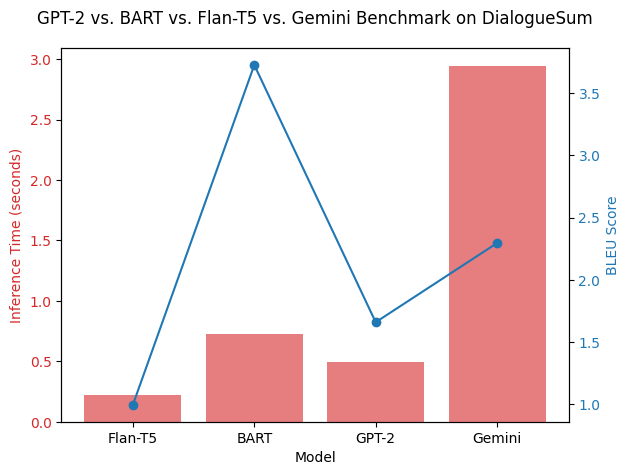

In [ ]:
import time
import torch
import matplotlib.pyplot as plt
import sacrebleu
import google.generativeai as genai
from transformers import (
    T5Tokenizer, T5ForConditionalGeneration,
    BartTokenizer, BartForConditionalGeneration,
    GPT2Tokenizer, GPT2LMHeadModel
)
from datasets import load_dataset

# ========== Load the DialogueSum dataset ==========
dataset = load_dataset("knkarthick/dialogsum")
test_data = dataset["test"]

# Select a subset of test dialogues for benchmarking
num_samples = 5 # Reduce for API cost efficiency
test_texts = test_data["dialogue"][:num_samples]
reference_summaries = test_data["summary"][:num_samples]

# ========== Load Hugging Face Models ==========
model_configs = {
    "Flan-T5": {
        "model_name": "google/flan-t5-small",
        "tokenizer": T5Tokenizer,
        "model": T5ForConditionalGeneration
    },
    "BART": {
        "model_name": "facebook/bart-large-cnn",
        "tokenizer": BartTokenizer,
        "model": BartForConditionalGeneration
    },
    "GPT-2": {
        "model_name": "gpt2",
        "tokenizer": GPT2Tokenizer,
        "model": GPT2LMHeadModel
    }
}

# Load models into GPU
for key in model_configs:
    model_configs[key]["tokenizer"] = model_configs[key]["tokenizer"].from_pretrained(model_configs[key]["model_name"])
    model_configs[key]["model"] = model_configs[key]["model"].from_pretrained(model_configs[key]["model_name"]).to("cuda")

    # Fix for GPT-2: Set padding token
    if key == "GPT-2":
        model_configs[key]["tokenizer"].pad_token = model_configs[key]["tokenizer"].eos_token

# ========== Function to Benchmark Hugging Face Models ==========
def benchmark_model(model, tokenizer, texts, is_gpt=False):
    inference_times = []
    generated_summaries = []

    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to("cuda")

        start_time = time.time()

        if is_gpt:
            output_ids = model.generate(
                inputs["input_ids"],
                max_new_tokens=50,
                pad_token_id=tokenizer.pad_token_id  # GPT-2 needs explicit padding
            )
        else:
            output_ids = model.generate(**inputs, max_new_tokens=50)

        output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

        end_time = time.time()
        inference_times.append(end_time - start_time)
        generated_summaries.append(output_text)

    return generated_summaries, sum(inference_times) / len(inference_times)  # Return avg time

# ========== Benchmark Gemini (via API) ==========
GEMINI_API_KEY = "api_key"  # <-- Replace with your actual API key
genai.configure(api_key=GEMINI_API_KEY)
gemini_model = genai.GenerativeModel("gemini-1.5-pro")

def benchmark_gemini(texts):
    inference_times = []
    generated_summaries = []

    for text in texts:
        start_time = time.time()

        response = gemini_model.generate_content(f"Summarize this dialogue: {text}")
        output_text = response.text if response.text else "No response"

        end_time = time.time()
        inference_times.append(end_time - start_time)
        generated_summaries.append(output_text)

    return generated_summaries, sum(inference_times) / len(inference_times)

# ========== Run Benchmarks ==========
results = {}

# Hugging Face Models
for model_name, config in model_configs.items():
    print(f"Benchmarking {model_name}...")
    is_gpt = (model_name == "GPT-2")
    summaries, avg_time = benchmark_model(config["model"], config["tokenizer"], test_texts, is_gpt)
    bleu_score = sacrebleu.corpus_bleu(summaries, [reference_summaries]).score
    results[model_name] = {"bleu": bleu_score, "time": avg_time}

# Gemini Model
print("Benchmarking Gemini...")
gemini_summaries, gemini_time = benchmark_gemini(test_texts)
gemini_bleu = sacrebleu.corpus_bleu(gemini_summaries, [reference_summaries]).score
results["Gemini"] = {"bleu": gemini_bleu, "time": gemini_time}

# ========== Plot Results ==========
models = list(results.keys())
inference_times = [results[m]["time"] for m in models]
bleu_scores = [results[m]["bleu"] for m in models]

fig, ax1 = plt.subplots()

ax1.set_xlabel("Model")
ax1.set_ylabel("Inference Time (seconds)", color="tab:red")
ax1.bar(models, inference_times, color="tab:red", alpha=0.6, label="Inference Time")
ax1.tick_params(axis="y", labelcolor="tab:red")

ax2 = ax1.twinx()
ax2.set_ylabel("BLEU Score", color="tab:blue")
ax2.plot(models, bleu_scores, color="tab:blue", marker="o", label="BLEU Score")
ax2.tick_params(axis="y", labelcolor="tab:blue")

fig.suptitle("GPT-2 vs. BART vs. Flan-T5 vs. Gemini Benchmark on DialogueSum")
fig.tight_layout()
plt.show()


Benchmarking Flan-T5...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Benchmarking BART...
Benchmarking GPT-2...


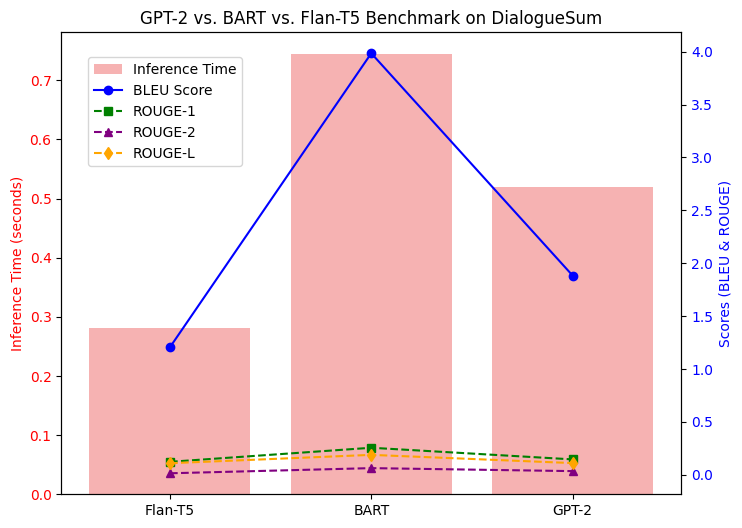

In [ ]:
import time
import torch
import matplotlib.pyplot as plt
import sacrebleu
from rouge_score import rouge_scorer
from transformers import (
    T5Tokenizer, T5ForConditionalGeneration,
    BartTokenizer, BartForConditionalGeneration,
    GPT2Tokenizer, GPT2LMHeadModel
)
from datasets import load_dataset
import numpy as np

# Load the DialogueSum dataset
dataset = load_dataset("knkarthick/dialogsum")
test_data = dataset["test"]

# Load the models and tokenizers
model_configs = {
    "Flan-T5": {
        "model_name": "google/flan-t5-small",
        "tokenizer": T5Tokenizer,
        "model": T5ForConditionalGeneration
    },
    "BART": {
        "model_name": "facebook/bart-large-cnn",
        "tokenizer": BartTokenizer,
        "model": BartForConditionalGeneration
    },
    "GPT-2": {
        "model_name": "gpt2",
        "tokenizer": GPT2Tokenizer,
        "model": GPT2LMHeadModel
    }
}

# Load models into GPU
for key in model_configs:
    model_configs[key]["tokenizer"] = model_configs[key]["tokenizer"].from_pretrained(model_configs[key]["model_name"])
    model_configs[key]["model"] = model_configs[key]["model"].from_pretrained(model_configs[key]["model_name"]).to("cuda")

    # Fix for GPT-2: Set padding token
    if key == "GPT-2":
        model_configs[key]["tokenizer"].pad_token = model_configs[key]["tokenizer"].eos_token

# Select a subset of test dialogues for benchmarking
num_samples = 100  # Change this for a larger benchmark
test_texts = test_data["dialogue"][:num_samples]
reference_summaries = test_data["summary"][:num_samples]

def calculate_rouge_scores(references, predictions):
    """
    Compute ROUGE-1, ROUGE-2, and ROUGE-L scores.
    """
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    rouge1_scores, rouge2_scores, rougeL_scores = [], [], []

    for ref, pred in zip(references, predictions):
        scores = scorer.score(ref, pred)
        rouge1_scores.append(scores['rouge1'].fmeasure)
        rouge2_scores.append(scores['rouge2'].fmeasure)
        rougeL_scores.append(scores['rougeL'].fmeasure)

    return {
        "ROUGE-1": np.mean(rouge1_scores),
        "ROUGE-2": np.mean(rouge2_scores),
        "ROUGE-L": np.mean(rougeL_scores),
    }

def benchmark_model(model, tokenizer, texts, is_gpt=False):
    """
    Runs benchmarking on a given model.
    """
    inference_times = []
    generated_summaries = []

    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to("cuda")

        start_time = time.time()

        if is_gpt:
            output_ids = model.generate(
                inputs["input_ids"],
                max_new_tokens=50,
                pad_token_id=tokenizer.pad_token_id  # GPT-2 needs explicit padding
            )
        else:
            output_ids = model.generate(**inputs, max_new_tokens=50)

        output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

        end_time = time.time()
        inference_times.append(end_time - start_time)
        generated_summaries.append(output_text)

    return generated_summaries, sum(inference_times) / len(inference_times)  # Return avg time

# Run benchmarks
results = {}
for model_name, config in model_configs.items():
    print(f"Benchmarking {model_name}...")
    is_gpt = (model_name == "GPT-2")
    summaries, avg_time = benchmark_model(config["model"], config["tokenizer"], test_texts, is_gpt)

    bleu_score = sacrebleu.corpus_bleu(summaries, [reference_summaries]).score
    rouge_scores = calculate_rouge_scores(reference_summaries, summaries)

    results[model_name] = {
        "bleu": bleu_score,
        "time": avg_time,
        "rouge": rouge_scores
    }

# Extract results for plotting
models = list(results.keys())
inference_times = [results[m]["time"] for m in models]
bleu_scores = [results[m]["bleu"] for m in models]

rouge_1_scores = [results[m]["rouge"]["ROUGE-1"] for m in models]
rouge_2_scores = [results[m]["rouge"]["ROUGE-2"] for m in models]
rouge_L_scores = [results[m]["rouge"]["ROUGE-L"] for m in models]

# Plot results
fig, ax1 = plt.subplots(figsize=(8, 6))

# Bar plot for Inference Time
ax1.bar(models, inference_times, color='lightcoral', alpha=0.6, label="Inference Time")
ax1.set_ylabel("Inference Time (seconds)", color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Second y-axis for BLEU & ROUGE
ax2 = ax1.twinx()
ax2.set_ylabel("Scores (BLEU & ROUGE)", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Line plots for BLEU and ROUGE scores
ax2.plot(models, bleu_scores, marker='o', linestyle='-', color='blue', label="BLEU Score")
ax2.plot(models, rouge_1_scores, marker='s', linestyle='--', color='green', label="ROUGE-1")
ax2.plot(models, rouge_2_scores, marker='^', linestyle='--', color='purple', label="ROUGE-2")
ax2.plot(models, rouge_L_scores, marker='d', linestyle='--', color='orange', label="ROUGE-L")

# Add a title
plt.title("GPT-2 vs. BART vs. Flan-T5 Benchmark on DialogueSum")

# Combine legends
fig.legend(loc="upper left", bbox_to_anchor=(0.15, 0.85))

# Show plot
plt.show()
